### PCA example
PCA to najbardziej popularny algorytm redukcji wymiarów. W ogólnym skrócie polega on na rzutowaniu danych do przestrzeni o mniejszej liczbie wymiarów tak, aby jak najlepiej zachować strukturę danych. 

Poniżej przykład wykorzystania PCA do redukcji wymiarów na podstawie zbioru o Bankach na podstawie raportów dostępnych na stronie www.PRnews.pl na dzień 2019-10-15.

In [1]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.decomposition import PCA

seed = 2019

#### Import danych

In [2]:
df = pd.read_excel('../data/data.xlsx', sheet_name='dataframe')
df.sort_values(by='2019Q2_aktywa', ascending=False).head()

,Nazwa,2019Q2_aktywa,2019Q1_aktywa,2018Q2_aktywa,2019Q2_mobile,2019Q1_mobile,2018Q2_mobile,2019Q2_internet,2019Q1_internet,2018Q2_internet,...,2018Q2_placowki,2019Q2_partner,2019Q1_partner,2018Q2_partner,2019Q2_etat,2019Q1_etat,2018Q2_etat,2019Q2_etat_grupa,2019Q1_etat_grupa,2018Q2_etat_grupa
12,PKO BP,301339000,298403000,276088000,2136646,2012570,1534243,8680400,10935000,10262200,...,1176,535,557,600,24100,24200,24700,28100,27900,28500
2,Bank Pekao,189574297,189494130,178781524,889475,778537,623599,3340969,3330006,3171625,...,851,-1,-1,-1,14436,14591,15182,16613,16815,17307
14,Santander Bank Polska,181300141,185555589,147610558,1111843,1048828,814928,3904082,3825991,3259127,...,540,124,124,113,11113,11695,11174,14058,14642,14286
10,ING Bank Śląski,147057000,142042800,127108000,1372000,1288000,1014585,3975000,3894000,3605069,...,352,-1,-1,-1,7693,7644,7630,8119,8063,8026
11,mBank,143942202,142564251,132012206,1673786,1571093,1296379,3928090,3914732,3676510,...,140,41,41,41,5993,5919,5682,6677,6576,6358


#### Preprocessing zbioru: standaryzacja i obsłużenie pustych wartości.   

Przed wykonaniem PCA należy dokonać standaryzacji zbioru danych (średnia = 0, wariancja = 1) ze względu na różną skalę jaka może występować w zmiennych - np. waga i dochody. Dane są następnie nnormalizowane (skalowane do przedziału [0,1]).
<br/>

Dodatkowo implementacja PCA w pakiecie scikit-learn nie obsługuje pustych wartości, dlatego też należy odpowiednio je obsłużyć. 
<br/>

**Uwaga**: W tym przypadku zapominamy, że mamy jakikolwiek zbiór do walidacji\testowania modelu (jak ma to miejsce dla uczenia nadzorowanego) i wykonujemy funkcję fit_transform() na całym zbiorze (który może być traktowany jako zbiór treningowy). Dla uczenia nadzorowanego wykonywalibyśmy też krok następny, czyli funkcję transform() na zbiorze walidacyjnym\testowym.

In [3]:
def apply_scalers(df, columns_to_exclude=None):
    if columns_to_exclude:
        exclude_filter = ~df.columns.isin(columns_to_exclude) 
    else:
        exclude_filter = ~df.columns.isin([]) 
    for column in df.iloc[:, exclude_filter].columns:
        df[column] = df[column].astype(float)

    df.loc[:, exclude_filter] = StandardScaler().fit_transform(df.loc[:, exclude_filter])
    return df

df = apply_scalers(df, columns_to_exclude=['Nazwa'])
df.sort_values(by='2019Q2_aktywa', ascending=False).head()

,Nazwa,2019Q2_aktywa,2019Q1_aktywa,2018Q2_aktywa,2019Q2_mobile,2019Q1_mobile,2018Q2_mobile,2019Q2_internet,2019Q1_internet,2018Q2_internet,...,2018Q2_placowki,2019Q2_partner,2019Q1_partner,2018Q2_partner,2019Q2_etat,2019Q1_etat,2018Q2_etat,2019Q2_etat_grupa,2019Q1_etat_grupa,2018Q2_etat_grupa
12,PKO BP,2.439176,2.451434,2.549791,2.272044,2.289286,2.208174,2.870860,3.180157,3.212267,...,2.699725,0.087071,0.104621,0.147944,2.867369,2.842515,2.940044,2.707886,2.691490,2.777432
2,Bank Pekao,1.170632,1.173505,1.287303,0.430077,0.354995,0.389769,0.495076,0.363630,0.395437,...,1.632315,-0.387541,-0.389552,-0.382783,1.243987,1.244292,1.360658,1.237344,1.274860,1.356310
14,Santander Bank Polska,1.076719,1.127290,0.882881,0.758496,0.778664,0.771821,0.745633,0.547319,0.430198,...,0.610887,-0.276857,-0.278850,-0.282112,0.685782,0.762614,0.695584,0.910259,0.997157,0.972748
10,ING Bank Śląski,0.688055,0.616714,0.616873,1.142726,1.153556,1.170503,0.777188,0.572506,0.567629,...,-0.006569,-0.387541,-0.389552,-0.382783,0.111283,0.088829,0.107505,0.149960,0.156381,0.177946
11,mBank,0.652702,0.622833,0.680502,1.588438,1.597291,1.733199,0.756316,0.580184,0.596010,...,-0.702848,-0.350351,-0.352356,-0.345694,-0.174287,-0.198083,-0.215740,-0.034642,-0.033653,-0.033832


#### PCA

W celu wykonania analizy głównych składowych można wykorzystać funkcję *PCA* z pakietu *sklearn.decomposition*. Najważniejsze parametry funkcji: 

* *n_components* - liczba *n* czynników w nowej przestrzeni 
* *svd_solver* - typ dekompozycji macierzy. Dostępne wartości: *auto, full, arpack, randomized*

Więcej o parametrach: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

In [4]:
# kolumny do wykluczenia (te na których nie chcemy PCA)
exclude_filter = ~df.columns.isin(['Nazwa']) 
# liczba głównych składowych
pca = PCA(n_components = 3)
# przeliczenie
principal_components = pca.fit_transform(df.loc[:, exclude_filter])

In [5]:
principal_df = pd.DataFrame(data = principal_components, 
                           columns = ['principal component 1', 'principal component 2', 'principal component 3'])

principal_df['Nazwa'] = df['Nazwa']
principal_df

,principal component 1,principal component 2,principal component 3,Nazwa
0,0.077224,-0.478463,-0.087593,Alior Bank
1,-0.155617,-1.011251,-1.684940,Bank Millennium
2,5.806928,1.201618,4.169210,Bank Pekao
3,-5.294890,2.552920,-1.466663,Bank Pocztowy
4,-0.352859,0.743658,3.437079,BNP Paribas
5,-5.629305,0.439033,-0.216447,BOŚ Bank
6,-4.457429,-0.159757,0.291037,Citi Handlowy
7,-3.445918,0.670329,0.131263,Credit Agricole
8,-4.288005,0.907453,-0.374221,Eurobank
9,-4.828903,1.215840,0.050449,Getin Noble Bank


In [6]:
import pandas as pd
import seaborn as sns

import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

init_notebook_mode(connected=True)

In [7]:
trace0 = go.Scatter(
    x = principal_df['principal component 1'],
    y = principal_df['principal component 2'],
    text=principal_df['Nazwa'],
    textposition="top center",
    name = 'Piony',
    mode = 'markers+text',
    marker = dict(
        size = 10,
        color = 'rgb(228,26,28)',
        line = dict(
            width = 1,
            color = 'rgb(0, 0, 0)'
        )
    )
)

data = [trace0]

layout = dict(title = 'Podobieństwo Banków na podstawie PCA',
              yaxis = dict(zeroline = False, title ='PC2 (principal component 2)'),
              xaxis = dict(zeroline = False, title ='PC1 (principal component 1)')
             )

fig = dict(data=data, layout=layout)
iplot(fig, filename='styled-scatter')

#### PCA - jak dobrać liczbę komponentów? 

Pierwszym ze sposób jest wizualizacja skumulowanej wartości wariancji w zależności od liczby komponentów. Z wykresu można  odczytać, że 4 pierwszych czynników może wyjaśnić ponad 95% całkowitej wariancji.  

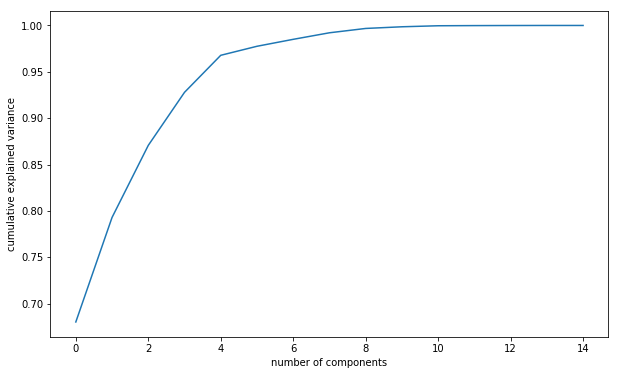

In [8]:
import numpy as np
pca = PCA().fit(df.loc[:, exclude_filter])
plt.figure(figsize=(10,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

##### Wykorzystanie parametru svd_solver.

Jeżeli **0 < *n_components* < 1** oraz ***svd_solver = 'full'*** to funkcja PCA wybiera liczbę komponentów, tak aby wielkość wariancji, którą należy wyjaśnić, była większa niż procent określony przez *n_components*.

In [9]:
pca = PCA(svd_solver='full', n_components=0.95)
principal_components = pca.fit_transform(df.loc[:, exclude_filter])
principal_df = pd.DataFrame(data=principal_components)
principal_df.head()

,0,1,2,3,4
0,0.077224,-0.478463,-0.087593,0.572624,-0.339989
1,-0.155617,-1.011251,-1.684940,-0.574601,-1.846124
2,5.806928,1.201618,4.169210,-0.470419,3.186590
3,-5.294890,2.552920,-1.466663,5.367300,1.030006
4,-0.352859,0.743658,3.437079,0.144013,-1.211092
